# analyzing len experiment

In [108]:
import json
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from pathlib import Path

plt.style.use('seaborn-v0_8')
%matplotlib inline


In [109]:
# Base directory
base_dir = "/mnt/polished-lake/home/annabelma/other/results_fixed/continuous/continuous_soft_prompt_len_10epochs"

print(f"Results directory: {base_dir}")


Results directory: /mnt/polished-lake/home/annabelma/other/results_fixed/continuous/continuous_soft_prompt_len_10epochs


In [110]:
def load_all_histories(directory):
    """Load all history JSON files from a directory."""
    histories = {}
    
    # Find all history files
    history_files = glob.glob(os.path.join(directory, "history_*.json"))
    
    for filepath in history_files:
        # Parse filename: history_adversarial_{True/False}_lr_{lr}_promptlen_{promptlen}.json
        filename = os.path.basename(filepath)
        match = re.match(r"history_adversarial_(True|False)_lr_([0-9.e-]+)_promptlen_(\d+)\.json", filename)
        
        if match:
            adversarial_str = match.group(1)
            adversarial = adversarial_str == "True"
            lr_val = float(match.group(2))
            prompt_len = int(match.group(3))
            
            with open(filepath, 'r') as f:
                history = json.load(f)
            
            key = (adversarial, lr_val, prompt_len)
            histories[key] = history
            print(f"Loaded: adversarial={adversarial}, lr={lr_val}, prompt_len={prompt_len}")
    
    return histories


In [111]:
# Load histories
print("Loading all histories...")
all_histories = load_all_histories(base_dir)

# Separate by adversarial flag
non_adv_histories = {(adv, lr, pl): h for (adv, lr, pl), h in all_histories.items() if not adv}
adv_histories = {(adv, lr, pl): h for (adv, lr, pl), h in all_histories.items() if adv}

print(f"\nNon-adversarial: {len(non_adv_histories)} runs")
print(f"Adversarial: {len(adv_histories)} runs")


Loading all histories...
Loaded: adversarial=False, lr=0.0001, prompt_len=1
Loaded: adversarial=False, lr=0.0001, prompt_len=10
Loaded: adversarial=False, lr=0.0001, prompt_len=100
Loaded: adversarial=False, lr=0.0001, prompt_len=20
Loaded: adversarial=False, lr=0.0001, prompt_len=5
Loaded: adversarial=False, lr=0.0001, prompt_len=50
Loaded: adversarial=False, lr=0.001, prompt_len=100
Loaded: adversarial=False, lr=0.001, prompt_len=20
Loaded: adversarial=False, lr=0.001, prompt_len=50
Loaded: adversarial=False, lr=0.01, prompt_len=100
Loaded: adversarial=False, lr=0.01, prompt_len=50
Loaded: adversarial=True, lr=0.001, prompt_len=1
Loaded: adversarial=True, lr=0.001, prompt_len=10
Loaded: adversarial=True, lr=0.001, prompt_len=100
Loaded: adversarial=True, lr=0.001, prompt_len=20
Loaded: adversarial=True, lr=0.001, prompt_len=5
Loaded: adversarial=True, lr=0.001, prompt_len=50
Loaded: adversarial=True, lr=0.01, prompt_len=100
Loaded: adversarial=True, lr=0.01, prompt_len=20
Loaded: adv

In [112]:
def plot_learning_curves(histories, title_prefix="", max_epochs=None, select_best_lr=True):
    """Plot learning curves for continuous soft prompts, grouped by learning rate.
    
    Args:
        histories: Dictionary of histories
        title_prefix: Prefix for plot titles
        max_epochs: Maximum number of epochs to plot (None = plot all)
        select_best_lr: If True, for non-adversarial select LR with best final acc,
                       for adversarial select LR with worst final acc
    """
    
    if not histories:
        print("No histories to plot")
        return []
    
    # If select_best_lr, filter to keep only the best/worst LR for each prompt length
    if select_best_lr:
        # Determine if this is adversarial or non-adversarial based on first history
        is_adversarial = next(iter(histories.keys()))[0]
        
        # Group by prompt length
        prompt_lengths = sorted(set(k[2] for k in histories.keys()))
        filtered_histories = {}
        
        for pl in prompt_lengths:
            # Get all histories for this prompt length
            pl_histories = {(adv, lr, p): h for (adv, lr, p), h in histories.items() if p == pl}
            
            if is_adversarial:
                # For adversarial: select LR with WORST final accuracy
                best_key = min(pl_histories.items(), key=lambda x: x[1]['val_acc'][-1])
            else:
                # For non-adversarial: select LR with BEST final accuracy
                best_key = max(pl_histories.items(), key=lambda x: x[1]['val_acc'][-1])
            
            filtered_histories[best_key[0]] = best_key[1]
            selected_lr = best_key[0][1]
            final_acc = best_key[1]['val_acc'][-1]
            print(f"  Prompt length {pl}: LR={selected_lr:.0e} (final acc={final_acc:.4f})")
        
        histories = filtered_histories
        print(f"Selected {'worst' if is_adversarial else 'best'} LR for each prompt length")
        
        # When select_best_lr=True, plot everything on one figure, labeled by prompt length only
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f"{title_prefix}Continuous Soft Prompt Learning Curves", fontsize=16, fontweight='bold')
        
        # Plot 1: Training Task Loss
        ax1 = axes[0, 0]
        for (adv, lr_val, pl), history in sorted(histories.items()):
            if 'train_task' in history:
                data = history['train_task'][:max_epochs] if max_epochs else history['train_task']
                epochs = range(1, len(data) + 1)
                ax1.plot(epochs, data, marker='o', label=f"prompt_len={pl}", linewidth=2, markersize=6)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Training Task Loss')
        ax1.set_title(f'Continuous Soft Prompt: Training Task Loss')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Validation Loss
        ax2 = axes[0, 1]
        for (adv, lr_val, pl), history in sorted(histories.items()):
            data = history['val_loss'][:max_epochs] if max_epochs else history['val_loss']
            epochs = range(1, len(data) + 1)
            ax2.plot(epochs, data, marker='o', label=f"prompt_len={pl}", linewidth=2, markersize=6)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Validation Loss')
        ax2.set_title(f'Continuous Soft Prompt: Validation Loss')
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Validation Accuracy
        ax3 = axes[1, 0]
        for (adv, lr_val, pl), history in sorted(histories.items()):
            data = history['val_acc'][:max_epochs] if max_epochs else history['val_acc']
            epochs = range(1, len(data) + 1)
            ax3.plot(epochs, data, marker='o', label=f"prompt_len={pl}", linewidth=2, markersize=6)
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Validation Accuracy')
        ax3.set_title(f'Continuous Soft Prompt: Validation Accuracy')
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Prompt Norm
        ax4 = axes[1, 1]
        for (adv, lr_val, pl), history in sorted(histories.items()):
            if 'prompt_norm' in history:
                data = history['prompt_norm'][:max_epochs] if max_epochs else history['prompt_norm']
                epochs = range(1, len(data) + 1)
                ax4.plot(epochs, data, marker='o', label=f"prompt_len={pl}", linewidth=2, markersize=6)
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Soft Prompt Norm (L2)')
        ax4.set_title(f'Continuous Soft Prompt: Prompt Norm')
        ax4.legend(fontsize=10)
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return [fig]
    
    # If not select_best_lr, group by learning rate (original behavior)
    lr_values = sorted(set(k[1] for k in histories.keys()))
    prompt_lengths = sorted(set(k[2] for k in histories.keys()))
    
    figs = []
    
    for lr in lr_values:
        # Filter histories for this learning rate
        lr_histories = {(adv, l, pl): h for (adv, l, pl), h in histories.items() if l == lr}
        
        if not lr_histories:
            continue
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f"{title_prefix}Continuous Soft Prompt Learning Curves - LR={lr:.0e}", fontsize=16, fontweight='bold')
        
        # Plot 1: Training Task Loss
        ax1 = axes[0, 0]
        for (adv, l, pl), history in sorted(lr_histories.items()):
            if 'train_task' in history:
                data = history['train_task'][:max_epochs] if max_epochs else history['train_task']
                epochs = range(1, len(data) + 1)
                ax1.plot(epochs, data, marker='o', label=f"prompt_len={pl}", linewidth=2, markersize=6)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Training Task Loss')
        ax1.set_title(f'Continuous Soft Prompt: Training Task Loss (LR={lr:.0e})')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Validation Loss
        ax2 = axes[0, 1]
        for (adv, l, pl), history in sorted(lr_histories.items()):
            data = history['val_loss'][:max_epochs] if max_epochs else history['val_loss']
            epochs = range(1, len(data) + 1)
            ax2.plot(epochs, data, marker='o', label=f"prompt_len={pl}", linewidth=2, markersize=6)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Validation Loss')
        ax2.set_title(f'Continuous Soft Prompt: Validation Loss (LR={lr:.0e})')
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Validation Accuracy
        ax3 = axes[1, 0]
        for (adv, l, pl), history in sorted(lr_histories.items()):
            data = history['val_acc'][:max_epochs] if max_epochs else history['val_acc']
            epochs = range(1, len(data) + 1)
            ax3.plot(epochs, data, marker='o', label=f"prompt_len={pl}", linewidth=2, markersize=6)
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Validation Accuracy')
        ax3.set_title(f'Continuous Soft Prompt: Validation Accuracy (LR={lr:.0e})')
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Prompt Norm
        ax4 = axes[1, 1]
        for (adv, l, pl), history in sorted(lr_histories.items()):
            if 'prompt_norm' in history:
                data = history['prompt_norm'][:max_epochs] if max_epochs else history['prompt_norm']
                epochs = range(1, len(data) + 1)
                ax4.plot(epochs, data, marker='o', label=f"prompt_len={pl}", linewidth=2, markersize=6)
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Soft Prompt Norm (L2)')
        ax4.set_title(f'Continuous Soft Prompt: Prompt Norm (LR={lr:.0e})')
        ax4.legend(fontsize=10)
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        figs.append(fig)
    
    return figs


Plotting non-adversarial continuous soft prompt learning curves...
  Prompt length 1: LR=1e-04 (final acc=0.4786)
  Prompt length 5: LR=1e-04 (final acc=0.4141)
  Prompt length 10: LR=1e-04 (final acc=0.6927)
  Prompt length 20: LR=1e-03 (final acc=0.7049)
  Prompt length 50: LR=1e-03 (final acc=0.7853)
  Prompt length 100: LR=1e-03 (final acc=0.8052)
Selected best LR for each prompt length


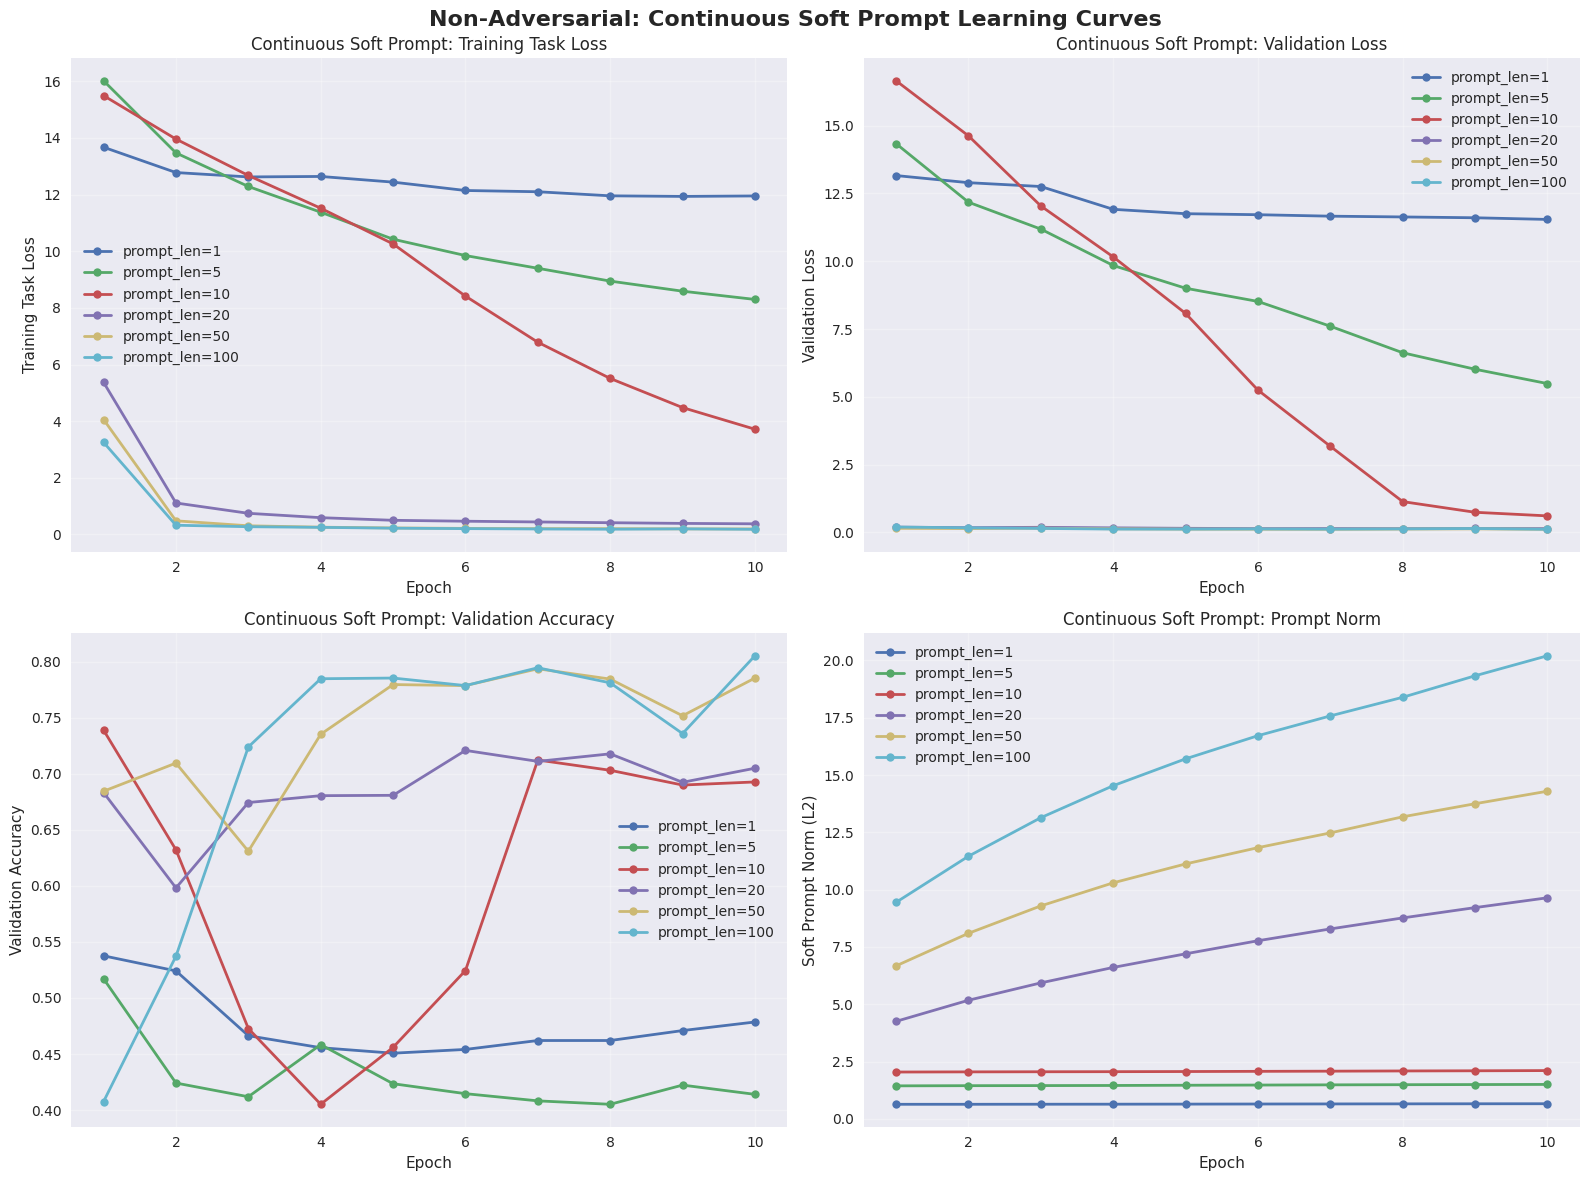

In [113]:
# Plot non-adversarial learning curves (select best LR for each prompt length)
print("Plotting non-adversarial continuous soft prompt learning curves...")
if non_adv_histories:
    figs_non_adv = plot_learning_curves(non_adv_histories, title_prefix="Non-Adversarial: ", select_best_lr=True)
    for fig in figs_non_adv:
        plt.show()
else:
    print("No non-adversarial continuous soft prompt histories found")


Plotting adversarial continuous soft prompt learning curves (first 5 epochs)...
  Prompt length 1: LR=1e-03 (final acc=0.4841)
  Prompt length 5: LR=1e-03 (final acc=0.5508)
  Prompt length 10: LR=1e-03 (final acc=0.7162)
  Prompt length 20: LR=1e-03 (final acc=0.6306)
  Prompt length 50: LR=1e-02 (final acc=0.6263)
  Prompt length 100: LR=1e-02 (final acc=0.4156)
Selected worst LR for each prompt length


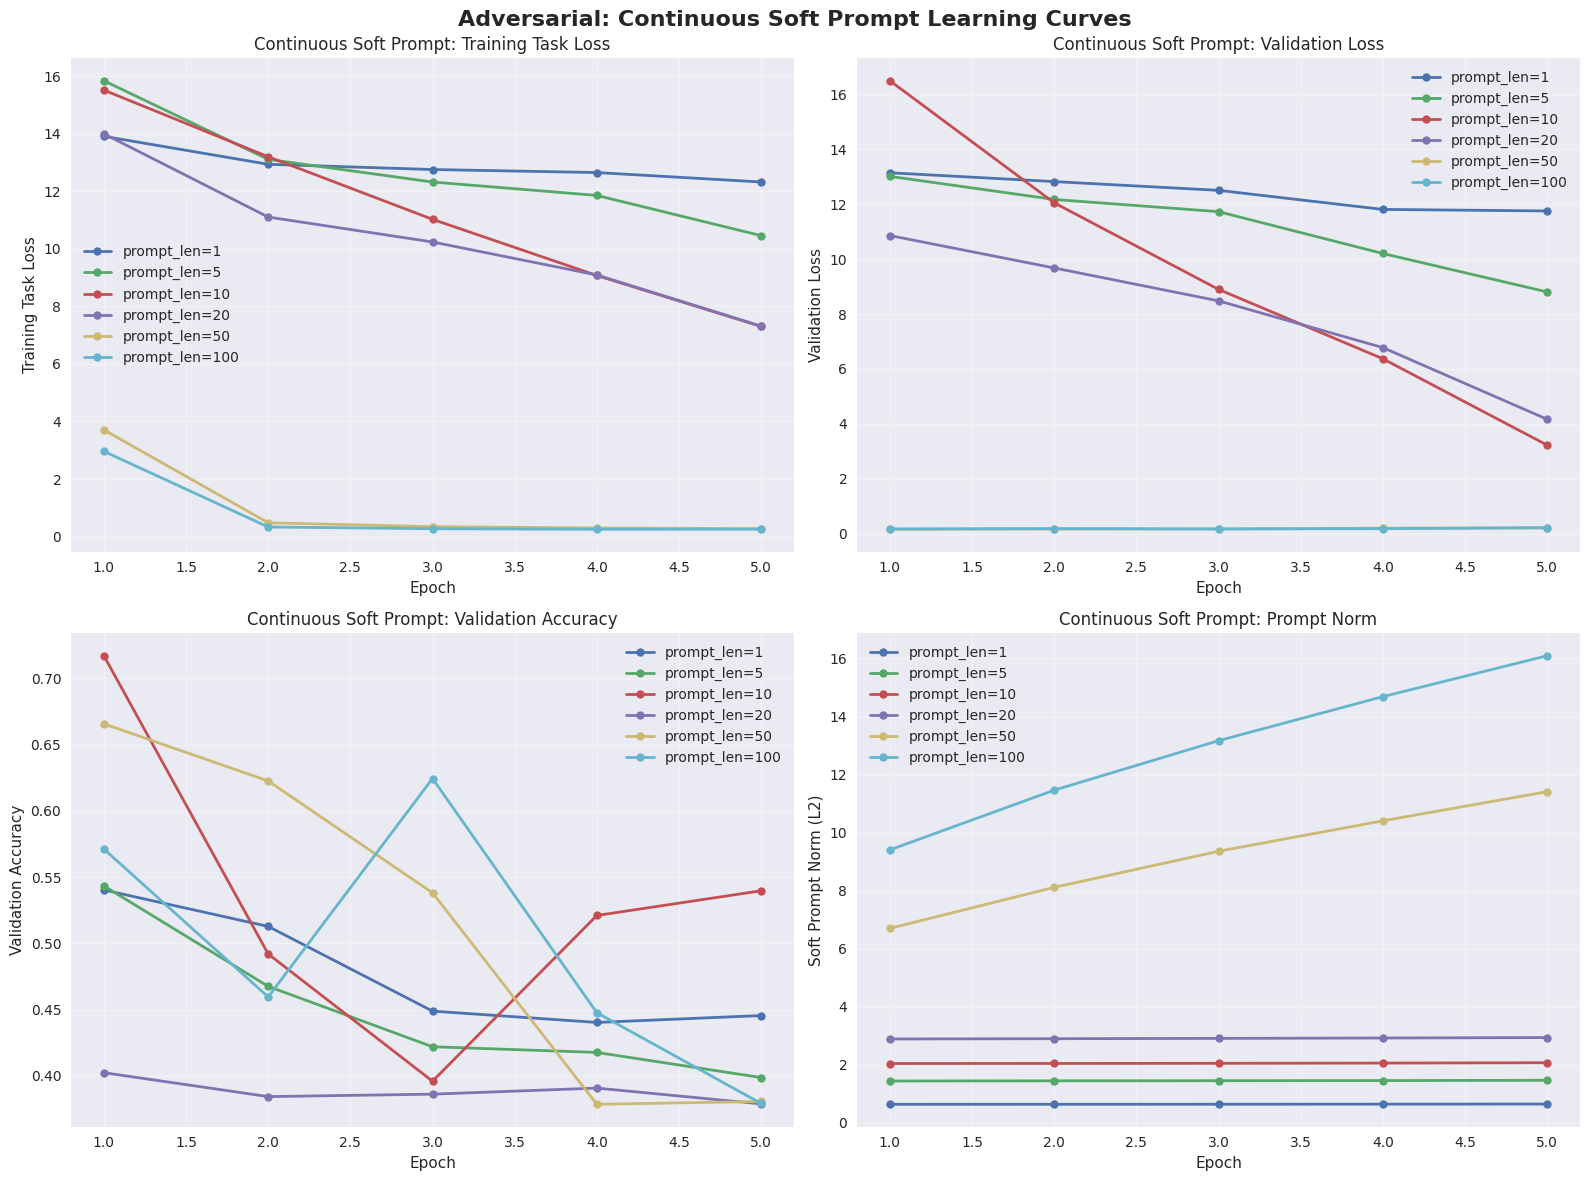

In [100]:
# Plot adversarial learning curves (only first 5 epochs, select worst LR for each prompt length)
print("Plotting adversarial continuous soft prompt learning curves (first 5 epochs)...")
if adv_histories:
    figs_adv = plot_learning_curves(adv_histories, title_prefix="Adversarial: ", max_epochs=5, select_best_lr=True)
    for fig in figs_adv:
        plt.show()
else:
    print("No adversarial continuous soft prompt histories found")


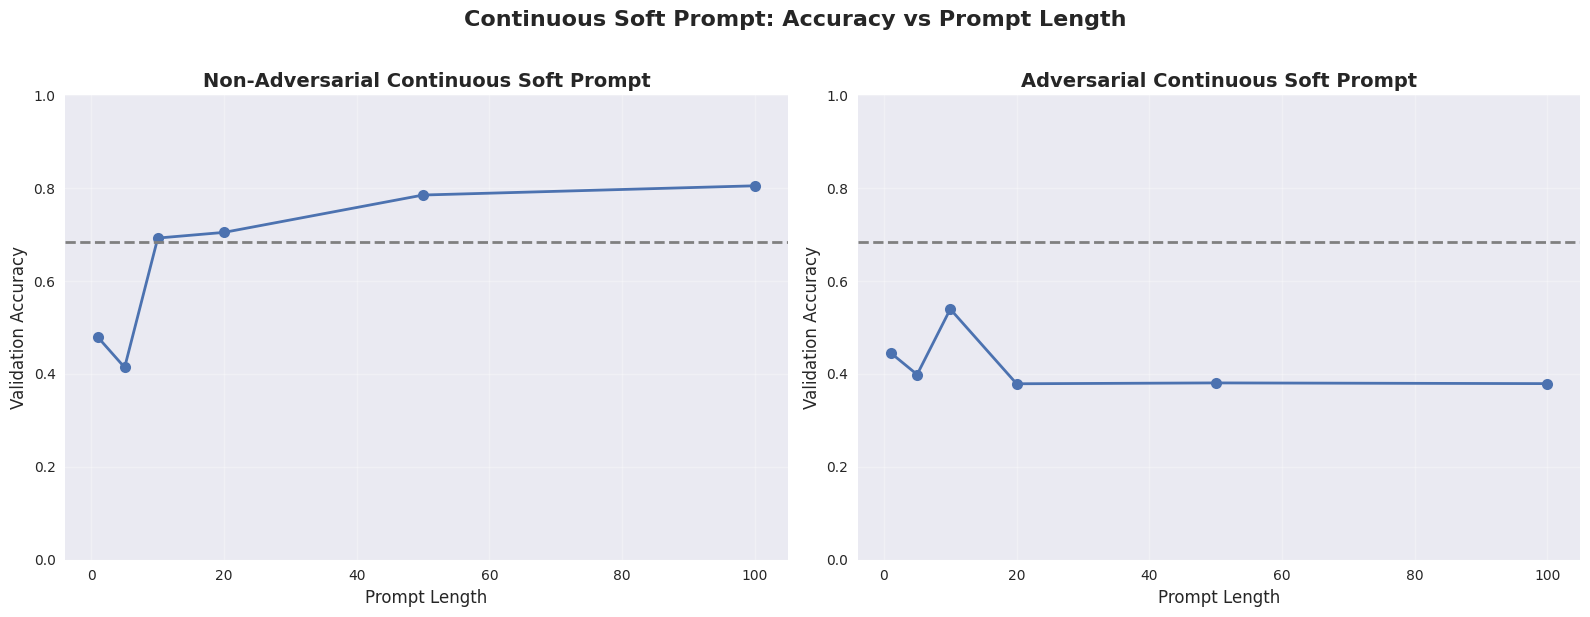

In [117]:
# Comparison plot: Accuracy vs Prompt Length
# For non-adversarial: epoch 10 accuracy with best LR
# For adversarial: epoch 5 accuracy with worst LR
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Continuous Soft Prompt: Accuracy vs Prompt Length', fontsize=16, fontweight='bold', y=1.02)

# Non-adversarial: Epoch 10 accuracy
if non_adv_histories:
    ax1 = axes[0]
    prompt_lengths = sorted(set(k[2] for k in non_adv_histories.keys()))
    epoch10_accs = []
    for pl in prompt_lengths:
        # Get all histories for this prompt length
        pl_histories = {(adv, lr, p): h for (adv, lr, p), h in non_adv_histories.items() if p == pl}
        # Select LR with BEST final accuracy
        best_key = max(pl_histories.items(), key=lambda x: x[1]['val_acc'][-1])
        history = best_key[1]
        # Get epoch 10 accuracy (index 9, since epochs are 1-indexed)
        if len(history['val_acc']) >= 10:
            epoch10_accs.append(history['val_acc'][9])
        else:
            epoch10_accs.append(None)
    
    # Filter out None values
    valid_data = [(pl, acc) for pl, acc in zip(prompt_lengths, epoch10_accs) if acc is not None]
    if valid_data:
        pls_valid, accs_valid = zip(*valid_data)
        ax1.plot(pls_valid, accs_valid, marker='o', linewidth=2, markersize=8)
    # Add zero-shot baseline
    ax1.axhline(y=0.6838, color='gray', linestyle='--', linewidth=2)
    ax1.set_xlabel('Prompt Length', fontsize=12)
    ax1.set_ylabel('Validation Accuracy', fontsize=12)
    ax1.set_title('Non-Adversarial Continuous Soft Prompt', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

# Adversarial: Epoch 5 accuracy
if adv_histories:
    ax2 = axes[1]
    prompt_lengths = sorted(set(k[2] for k in adv_histories.keys()))
    epoch5_accs = []
    for pl in prompt_lengths:
        # Get all histories for this prompt length
        pl_histories = {(adv, lr, p): h for (adv, lr, p), h in adv_histories.items() if p == pl}
        # Select LR with WORST final accuracy
        best_key = min(pl_histories.items(), key=lambda x: x[1]['val_acc'][-1])
        history = best_key[1]
        # Get epoch 5 accuracy (index 4, since epochs are 1-indexed)
        if len(history['val_acc']) >= 5:
            epoch5_accs.append(history['val_acc'][4])
        else:
            epoch5_accs.append(None)
    
    # Filter out None values
    valid_data = [(pl, acc) for pl, acc in zip(prompt_lengths, epoch5_accs) if acc is not None]
    if valid_data:
        pls_valid, accs_valid = zip(*valid_data)
        ax2.plot(pls_valid, accs_valid, marker='o', linewidth=2, markersize=8)
    # Add zero-shot baseline
    ax2.axhline(y=0.6838, color='gray', linestyle='--', linewidth=2)
    ax2.set_xlabel('Prompt Length', fontsize=12)
    ax2.set_ylabel('Validation Accuracy', fontsize=12)
    ax2.set_title('Adversarial Continuous Soft Prompt', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()


In [102]:
# Create table: Prompt Length vs Epoch (Validation Accuracy)
def create_epoch_accuracy_table(histories, metric='val_acc', select_best_lr=True):
    """Create a table with prompt lengths as rows and epochs as columns.
    
    Args:
        histories: Dictionary of histories
        metric: Which metric to use ('val_acc', 'val_acc_true', 'val_acc_false')
        select_best_lr: If True, for non-adversarial select LR with best final acc,
                       for adversarial select LR with worst final acc
    """
    
    if not histories:
        return None
    
    # If select_best_lr, filter to keep only the best/worst LR for each prompt length
    if select_best_lr:
        # Determine if this is adversarial or non-adversarial based on first history
        is_adversarial = next(iter(histories.keys()))[0]
        
        # Group by prompt length
        prompt_lengths = sorted(set(k[2] for k in histories.keys()))
        filtered_histories = {}
        
        for pl in prompt_lengths:
            # Get all histories for this prompt length
            pl_histories = {(adv, lr, p): h for (adv, lr, p), h in histories.items() if p == pl}
            
            if is_adversarial:
                # For adversarial: select LR with WORST final accuracy
                best_key = min(pl_histories.items(), key=lambda x: x[1]['val_acc'][-1])
            else:
                # For non-adversarial: select LR with BEST final accuracy
                best_key = max(pl_histories.items(), key=lambda x: x[1]['val_acc'][-1])
            
            filtered_histories[best_key[0]] = best_key[1]
        
        histories = filtered_histories
    
    # Get all prompt lengths and find max epochs
    prompt_lengths = sorted(set(k[2] for k in histories.keys()))
    max_epochs = 0
    
    # Find maximum number of epochs across all histories
    for (adv, lr, pl), history in histories.items():
        if metric in history:
            max_epochs = max(max_epochs, len(history[metric]))
    
    # Create table data
    table_data = []
    for pl in prompt_lengths:
        # Find a history for this prompt length
        row_data = {'Prompt Length': pl}
        for (adv, lr, p), history in histories.items():
            if p == pl and metric in history:
                # Fill in accuracies for each epoch
                for epoch_idx, acc in enumerate(history[metric], start=1):
                    row_data[f'Epoch {epoch_idx}'] = acc
                break
        table_data.append(row_data)
    
    # Create DataFrame
    df = pd.DataFrame(table_data)
    
    # Reorder columns: Prompt Length first, then epochs
    cols = ['Prompt Length'] + [f'Epoch {i}' for i in range(1, max_epochs + 1)]
    df = df.reindex(columns=[c for c in cols if c in df.columns])
    
    return df

# Create tables for non-adversarial (using best LR for each prompt length)
print("\n" + "=" * 80)
print("NON-ADVERSARIAL: Overall Validation Accuracy by Prompt Length and Epoch (Best LR)")
print("=" * 80)
if non_adv_histories:
    df_non_adv_total = create_epoch_accuracy_table(non_adv_histories, metric='val_acc', select_best_lr=True)
    if df_non_adv_total is not None:
        print(df_non_adv_total.to_string(index=False))
else:
    print("No non-adversarial histories found")

print("\n" + "=" * 80)
print("NON-ADVERSARIAL: True (Yes) Accuracy by Prompt Length and Epoch (Best LR)")
print("=" * 80)
if non_adv_histories:
    df_non_adv_true = create_epoch_accuracy_table(non_adv_histories, metric='val_acc_true', select_best_lr=True)
    if df_non_adv_true is not None:
        print(df_non_adv_true.to_string(index=False))
else:
    print("No non-adversarial histories found")

print("\n" + "=" * 80)
print("NON-ADVERSARIAL: False (No) Accuracy by Prompt Length and Epoch (Best LR)")
print("=" * 80)
if non_adv_histories:
    df_non_adv_false = create_epoch_accuracy_table(non_adv_histories, metric='val_acc_false', select_best_lr=True)
    if df_non_adv_false is not None:
        print(df_non_adv_false.to_string(index=False))
else:
    print("No non-adversarial histories found")

# Create tables for adversarial (using worst LR for each prompt length)
print("\n" + "=" * 80)
print("ADVERSARIAL: Overall Validation Accuracy by Prompt Length and Epoch (Worst LR)")
print("=" * 80)
if adv_histories:
    df_adv_total = create_epoch_accuracy_table(adv_histories, metric='val_acc', select_best_lr=True)
    if df_adv_total is not None:
        print(df_adv_total.to_string(index=False))
else:
    print("No adversarial histories found")

print("\n" + "=" * 80)
print("ADVERSARIAL: True (Yes) Accuracy by Prompt Length and Epoch (Worst LR)")
print("=" * 80)
if adv_histories:
    df_adv_true = create_epoch_accuracy_table(adv_histories, metric='val_acc_true', select_best_lr=True)
    if df_adv_true is not None:
        print(df_adv_true.to_string(index=False))
else:
    print("No adversarial histories found")

print("\n" + "=" * 80)
print("ADVERSARIAL: False (No) Accuracy by Prompt Length and Epoch (Worst LR)")
print("=" * 80)
if adv_histories:
    df_adv_false = create_epoch_accuracy_table(adv_histories, metric='val_acc_false', select_best_lr=True)
    if df_adv_false is not None:
        print(df_adv_false.to_string(index=False))
else:
    print("No adversarial histories found")



NON-ADVERSARIAL: Overall Validation Accuracy by Prompt Length and Epoch (Best LR)
 Prompt Length  Epoch 1  Epoch 2  Epoch 3  Epoch 4  Epoch 5  Epoch 6  Epoch 7  Epoch 8  Epoch 9  Epoch 10
             1 0.537615 0.524159 0.466361 0.455657 0.450765 0.454128 0.462080 0.462080 0.470948  0.478593
             5 0.517125 0.424159 0.411927 0.458410 0.423547 0.414679 0.408257 0.405199 0.422324  0.414067
            10 0.738838 0.632110 0.472783 0.405199 0.455963 0.524465 0.712232 0.703058 0.689908  0.692661
            20 0.683180 0.598165 0.674312 0.680428 0.680734 0.720795 0.711009 0.717737 0.692355  0.704893
            50 0.684404 0.709480 0.630887 0.735168 0.779511 0.778593 0.793578 0.784404 0.751682  0.785321
           100 0.407645 0.537309 0.723853 0.784709 0.785321 0.778593 0.794495 0.781040 0.735780  0.805199

NON-ADVERSARIAL: True (Yes) Accuracy by Prompt Length and Epoch (Best LR)
 Prompt Length  Epoch 1  Epoch 2  Epoch 3  Epoch 4  Epoch 5  Epoch 6  Epoch 7  Epoch 8  Epoch 9  Epo

In [104]:
# Unembed continuous soft prompts and calculate perplexity
import torch
import torch.nn as nn
import math
from transformers import (
    T5ForConditionalGeneration,
    T5TokenizerFast,
    GPT2LMHeadModel,
    GPT2TokenizerFast,
)

# Load GPT-2 for perplexity calculation
print("Loading GPT-2 for perplexity calculation...")
device = "cuda" if torch.cuda.is_available() else "cpu"
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
gpt2_model.eval()
for p in gpt2_model.parameters():
    p.requires_grad = False

# Load T5 tokenizer
t5_tokenizer = T5TokenizerFast.from_pretrained("t5-large")

def compute_prompt_ppl_loss_from_text(
    gpt2_model: GPT2LMHeadModel,
    gpt2_tokenizer: GPT2TokenizerFast,
    prompt_text: str,
    device: str,
) -> torch.Tensor:
    """Take decoded prompt text, feed to GPT-2, compute LM loss."""
    if not prompt_text or not prompt_text.strip():
        return torch.tensor(0.0, device=device)

    enc = gpt2_tokenizer(prompt_text, return_tensors="pt", truncation=True)
    input_ids = enc["input_ids"].to(device)

    if input_ids.numel() == 0:
        return torch.tensor(0.0, device=device)

    labels = input_ids.clone()
    with torch.no_grad():
        outputs = gpt2_model(input_ids=input_ids, labels=labels)
    return outputs.loss

def compute_prompt_ppl_with_stats(
    gpt2_model: GPT2LMHeadModel,
    gpt2_tokenizer: GPT2TokenizerFast,
    prompt_text: str,
    device: str,
):
    """Compute perplexity and return stats including token count."""
    if not prompt_text or not prompt_text.strip():
        return {
            'loss': torch.tensor(0.0, device=device),
            'perplexity': 0.0,
            'num_tokens': 0,
            'num_chars': 0
        }

    enc = gpt2_tokenizer(prompt_text, return_tensors="pt", truncation=True)
    input_ids = enc["input_ids"].to(device)

    if input_ids.numel() == 0:
        return {
            'loss': torch.tensor(0.0, device=device),
            'perplexity': 0.0,
            'num_tokens': 0,
            'num_chars': 0
        }

    labels = input_ids.clone()
    num_tokens = input_ids.numel()
    num_chars = len(prompt_text)
    
    with torch.no_grad():
        outputs = gpt2_model(input_ids=input_ids, labels=labels)
        loss = outputs.loss
        perplexity = math.exp(loss.item()) if not (torch.isnan(loss) or torch.isinf(loss)) else float('nan')
    
    return {
        'loss': loss,
        'perplexity': perplexity,
        'num_tokens': num_tokens,
        'num_chars': num_chars
    }

def unembed_continuous_prompt(soft_prompt_embeds, t5_model, device="cuda"):
    """
    Convert continuous soft prompt embeddings to discrete token IDs.
    Uses nearest neighbor search in embedding space.
    
    Args:
        soft_prompt_embeds: (prompt_length, d_model) tensor
        t5_model: T5 model to get embedding matrix from
        device: device to use
    
    Returns:
        token_ids: (prompt_length,) tensor of token IDs
    """
    # Get embedding matrix: (vocab_size, d_model)
    embed_matrix = t5_model.encoder.embed_tokens.weight  # (V, d_model)
    
    # Compute cosine similarity or L2 distance for each prompt position
    # soft_prompt_embeds: (L, d_model)
    # embed_matrix: (V, d_model)
    
    # Normalize for cosine similarity
    soft_prompt_norm = torch.nn.functional.normalize(soft_prompt_embeds, p=2, dim=1)  # (L, d_model)
    embed_matrix_norm = torch.nn.functional.normalize(embed_matrix, p=2, dim=1)  # (V, d_model)
    
    # Compute cosine similarity: (L, V)
    similarities = torch.matmul(soft_prompt_norm, embed_matrix_norm.t())
    
    # Get argmax for each position
    token_ids = similarities.argmax(dim=1)  # (L,)
    
    return token_ids

def decode_continuous_prompt(model_path, prompt_length, t5_tokenizer, t5_model, device="cuda"):
    """
    Load a continuous soft prompt model and decode it to text.
    
    Args:
        model_path: Path to saved model state dict
        prompt_length: Length of the prompt
        t5_tokenizer: T5 tokenizer
        t5_model: T5 model (to get embedding matrix)
        device: device to use
    
    Returns:
        prompt_text: Decoded text of the prompt
        token_ids: Token IDs
    """
    # Load model state dict
    state_dict = torch.load(model_path, map_location=device)
    
    # Extract soft_prompt parameter
    # The state dict should have 'soft_prompt' key
    if 'soft_prompt' in state_dict:
        soft_prompt_embeds = state_dict['soft_prompt'].to(device)
    else:
        # Try alternative key names (in case of nested structure)
        found = False
        for key in state_dict.keys():
            if 'soft_prompt' in key.lower():
                soft_prompt_embeds = state_dict[key].to(device)
                found = True
                break
        if not found:
            # Print available keys for debugging
            print(f"Available keys in {model_path}: {list(state_dict.keys())[:10]}")
            raise ValueError(f"Could not find soft_prompt in {model_path}. Available keys: {list(state_dict.keys())}")
    
    # Verify shape
    if soft_prompt_embeds.shape[0] != prompt_length:
        print(f"Warning: Expected prompt length {prompt_length}, got {soft_prompt_embeds.shape[0]}")
    
    # Unembed to get token IDs
    token_ids = unembed_continuous_prompt(soft_prompt_embeds, t5_model, device)
    
    # Decode to text
    prompt_text = t5_tokenizer.decode(
        token_ids.tolist(),
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True,
    ).strip()
    
    return prompt_text, token_ids

# Load T5 model for unembedding
print("Loading T5 model for unembedding...")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-large").to(device)
t5_model.eval()
for p in t5_model.parameters():
    p.requires_grad = False

print("Ready to unembed prompts and calculate perplexity.")


Loading GPT-2 for perplexity calculation...
Loading T5 model for unembedding...


Ready to unembed prompts and calculate perplexity.


In [105]:
# Unembed all prompts and calculate perplexity
print("\n" + "=" * 80)
print("UNEMBEDDING CONTINUOUS PROMPTS AND CALCULATING PERPLEXITY")
print("=" * 80)

prompt_results = []

for (adv, lr, pl), history in sorted(all_histories.items()):
    # Find corresponding model file
    model_filename = f"model_adversarial_{adv}_lr_{lr}_promptlen_{pl}.pt"
    model_path = os.path.join(base_dir, model_filename)
    
    if not os.path.exists(model_path):
        print(f"Warning: Model file not found: {model_path}")
        continue
    
    try:
        # Decode the prompt
        prompt_text, token_ids = decode_continuous_prompt(
            model_path, pl, t5_tokenizer, t5_model, device=device
        )
        
        # Calculate perplexity with stats
        if prompt_text:
            ppl_stats = compute_prompt_ppl_with_stats(
                gpt2_model, gpt2_tokenizer, prompt_text, device=device
            )
            ppl = ppl_stats['perplexity']
            ppl_loss = ppl_stats['loss']
            num_tokens = ppl_stats['num_tokens']
            num_chars = ppl_stats['num_chars']
        else:
            ppl_loss = torch.tensor(0.0, device=device)
            ppl = 0.0
            num_tokens = 0
            num_chars = 0
        
        prompt_results.append({
            'adversarial': adv,
            'lr': lr,
            'prompt_length': pl,
            'prompt_text': prompt_text,
            'token_ids': token_ids.tolist(),
            'perplexity': ppl,
            'ppl_loss': ppl_loss.item() if isinstance(ppl_loss, torch.Tensor) else ppl_loss,
            'num_tokens': num_tokens,
            'num_chars': num_chars
        })
        
        print(f"\nAdversarial={adv}, LR={lr:.0e}, Prompt Length={pl}:")
        print(f"  Prompt: {prompt_text}")
        print(f"  Perplexity: {ppl:.2f}")
        print(f"  GPT-2 tokens: {num_tokens}, chars: {num_chars}")
        
    except Exception as e:
        print(f"Error processing {model_path}: {e}")
        import traceback
        traceback.print_exc()

print(f"\nProcessed {len(prompt_results)} prompts.")



UNEMBEDDING CONTINUOUS PROMPTS AND CALCULATING PERPLEXITY

Adversarial=False, LR=1e-04, Prompt Length=1:
  Prompt: 
  Perplexity: 0.00
  GPT-2 tokens: 0, chars: 0

Adversarial=False, LR=1e-04, Prompt Length=5:
  Prompt: Uber Persoan Zusatzsavvy
  Perplexity: 20998.27
  GPT-2 tokens: 8, chars: 24

Adversarial=False, LR=1e-04, Prompt Length=10:
  Prompt: Kol model sheep wellness Ros Daniel Klein carte?
  Perplexity: 51241.06
  GPT-2 tokens: 11, chars: 48

Adversarial=False, LR=1e-04, Prompt Length=20:
  Prompt: miercuri model Nar Su heute Bh MonteArchitect nicely Sam dishwasher startup my Cal boxes windshieldchweis Photos shock
  Perplexity: 42145.20
  GPT-2 tokens: 27, chars: 118

Adversarial=False, LR=1e-04, Prompt Length=50:
  Prompt: FM Kendall sprinkle notice Ministercosm Toast stainless nicelybel necesar ERP dryingappropri telefonroadnos gameplay Winter Comun desktopUnsereVPATAcomP concentrate enclosure38 2018.interest Peter nickname buget Schm Verpflichtung chaise Library Bottle 


PROMPT PERPLEXITY BY PROMPT LENGTH
Adversarial Learning Rate  Prompt Length   Perplexity  GPT-2 Tokens  Chars                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Prompt Text
         No         1e-04              1     0.000000             0      0                                                                                                                                     

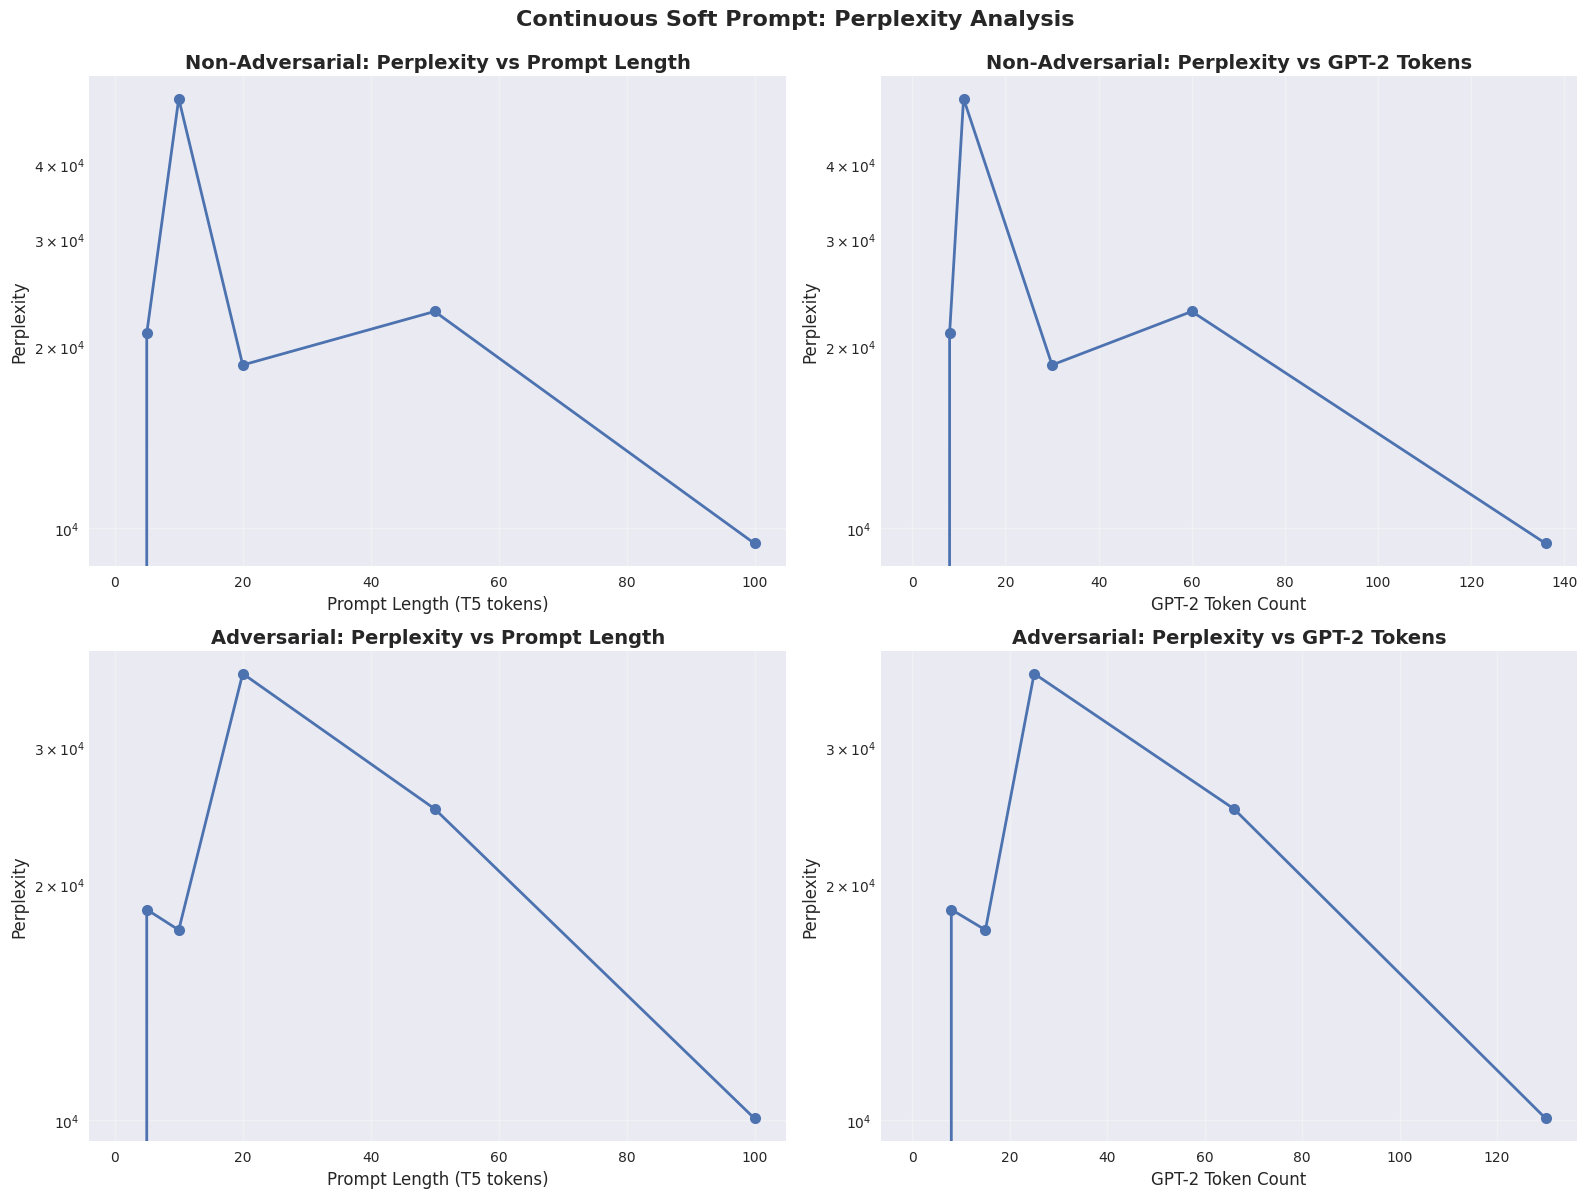

In [107]:
# Create table of prompt perplexity by prompt length
print("\n" + "=" * 80)
print("PROMPT PERPLEXITY BY PROMPT LENGTH")
print("=" * 80)

# Set pandas display options to show full text
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

# Create DataFrame
ppl_data = []
for result in prompt_results:
    ppl_data.append({
        'Adversarial': 'Yes' if result['adversarial'] else 'No',
        'Learning Rate': f"{result['lr']:.0e}",
        'Prompt Length': result['prompt_length'],
        'Perplexity': result['perplexity'],
        'GPT-2 Tokens': result.get('num_tokens', 0),
        'Chars': result.get('num_chars', 0),
        'Prompt Text': result['prompt_text']  # Full prompt text, no truncation
    })

df_ppl = pd.DataFrame(ppl_data)
print(df_ppl.to_string(index=False))

# Also print each prompt separately for better readability
print("\n" + "=" * 80)
print("FULL PROMPT TEXTS")
print("=" * 80)
for result in sorted(prompt_results, key=lambda x: (x['adversarial'], x['prompt_length'])):
    adv_str = "Adversarial" if result['adversarial'] else "Non-Adversarial"
    print(f"\n{adv_str}, LR={result['lr']:.0e}, Prompt Length={result['prompt_length']}:")
    print(f"  Perplexity: {result['perplexity']:.2f}")
    print(f"  Prompt: {result['prompt_text']}")

# Plot perplexity vs prompt length and token count
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Continuous Soft Prompt: Perplexity Analysis', fontsize=16, fontweight='bold', y=0.995)

# Non-adversarial - select best LR for each prompt length
non_adv_ppl = [r for r in prompt_results if not r['adversarial']]
if non_adv_ppl:
    prompt_lengths = sorted(set(r['prompt_length'] for r in non_adv_ppl))
    ppls = []
    token_counts = []
    selected_lrs = []
    print("\nNon-Adversarial: Selecting best LR for each prompt length (based on final accuracy):")
    for pl in prompt_lengths:
        # Get all results for this prompt length
        pl_results = [r for r in non_adv_ppl if r['prompt_length'] == pl]
        # Find corresponding histories to get final accuracy
        pl_histories = {(adv, lr, p): h for (adv, lr, p), h in non_adv_histories.items() if p == pl}
        if pl_histories:
            # Select LR with BEST final accuracy
            best_key = max(pl_histories.items(), key=lambda x: x[1]['val_acc'][-1])
            selected_lr = best_key[0][1]
            # Find the result with this LR
            for r in pl_results:
                if abs(r['lr'] - selected_lr) < 1e-10:  # Float comparison
                    ppls.append(r['perplexity'])
                    token_counts.append(r.get('num_tokens', 0))
                    selected_lrs.append(selected_lr)
                    print(f"  Prompt length {pl}: LR={selected_lr:.0e} (final acc={best_key[1]['val_acc'][-1]:.4f}, perplexity={r['perplexity']:.2f})")
                    break
    
    # Plot 1: Perplexity vs Prompt Length
    ax1 = axes[0, 0]
    ax1.plot(prompt_lengths, ppls, marker='o', linewidth=2, markersize=8)
    ax1.set_xlabel('Prompt Length (T5 tokens)', fontsize=12)
    ax1.set_ylabel('Perplexity', fontsize=12)
    ax1.set_title('Non-Adversarial: Perplexity vs Prompt Length', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # Plot 2: Perplexity vs GPT-2 Token Count
    ax2 = axes[0, 1]
    ax2.plot(token_counts, ppls, marker='o', linewidth=2, markersize=8)
    ax2.set_xlabel('GPT-2 Token Count', fontsize=12)
    ax2.set_ylabel('Perplexity', fontsize=12)
    ax2.set_title('Non-Adversarial: Perplexity vs GPT-2 Tokens', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')

# Adversarial - select worst LR for each prompt length
adv_ppl = [r for r in prompt_results if r['adversarial']]
if adv_ppl:
    prompt_lengths = sorted(set(r['prompt_length'] for r in adv_ppl))
    ppls = []
    token_counts = []
    selected_lrs = []
    print("\nAdversarial: Selecting worst LR for each prompt length (based on final accuracy):")
    for pl in prompt_lengths:
        # Get all results for this prompt length
        pl_results = [r for r in adv_ppl if r['prompt_length'] == pl]
        # Find corresponding histories to get final accuracy
        pl_histories = {(adv, lr, p): h for (adv, lr, p), h in adv_histories.items() if p == pl}
        if pl_histories:
            # Select LR with WORST final accuracy
            best_key = min(pl_histories.items(), key=lambda x: x[1]['val_acc'][-1])
            selected_lr = best_key[0][1]
            # Find the result with this LR
            for r in pl_results:
                if abs(r['lr'] - selected_lr) < 1e-10:  # Float comparison
                    ppls.append(r['perplexity'])
                    token_counts.append(r.get('num_tokens', 0))
                    selected_lrs.append(selected_lr)
                    print(f"  Prompt length {pl}: LR={selected_lr:.0e} (final acc={best_key[1]['val_acc'][-1]:.4f}, perplexity={r['perplexity']:.2f})")
                    break
    
    # Plot 3: Perplexity vs Prompt Length
    ax3 = axes[1, 0]
    ax3.plot(prompt_lengths, ppls, marker='o', linewidth=2, markersize=8)
    ax3.set_xlabel('Prompt Length (T5 tokens)', fontsize=12)
    ax3.set_ylabel('Perplexity', fontsize=12)
    ax3.set_title('Adversarial: Perplexity vs Prompt Length', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.set_yscale('log')
    
    # Plot 4: Perplexity vs GPT-2 Token Count
    ax4 = axes[1, 1]
    ax4.plot(token_counts, ppls, marker='o', linewidth=2, markersize=8)
    ax4.set_xlabel('GPT-2 Token Count', fontsize=12)
    ax4.set_ylabel('Perplexity', fontsize=12)
    ax4.set_title('Adversarial: Perplexity vs GPT-2 Tokens', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')

plt.tight_layout()
plt.show()
